In [193]:
import xgboost as XGB
import numpy as np
import optuna
import shap
import pickle
import os
import warnings
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import TimeSeriesSplit as tss
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

In [194]:
start_date = '2023-7-1'
end_date = '2023-7-31'

In [195]:
df = pd.read_csv('train_merged.csv')
target = 'speed_tomorrow'
ignore_features = ['end_code', 'start_code']
df['datetime'] = pd.to_datetime(df['datetime'])

coef_0 = 1
coef_1 = 1000

# sample_weightに入れる重みを計算
weight_reg = compute_sample_weight(class_weight='balanced', y=df['speed_tomorrow'])
weight_df = pd.DataFrame()
weight_df['speed_tomorrow'] = df['speed_tomorrow']
weight_df['weight_reg'] = weight_reg
weight_df.loc[weight_df['speed_tomorrow'] > 40, 'weight_reg'] = (weight_df[weight_df['speed_tomorrow'] > 40]['weight_reg'] * coef_0).set_axis(weight_df.loc[weight_df['speed_tomorrow'] > 40].index)
weight_df.loc[weight_df['speed_tomorrow'] <= 40, 'weight_reg'] = (weight_df[weight_df['speed_tomorrow'] <= 40]['weight_reg'] * coef_1).set_axis(weight_df.loc[weight_df['speed_tomorrow'] <= 40].index)
df['weight_reg'] = weight_df['weight_reg']

df_train = df[df['datetime'] < start_date+' 00:00:00']
df_train = df_train[df_train['tomorrow_holiday'] == 1]
df_test = df[(df['datetime'] >= start_date+' 00:00:00') & (df['datetime'] <= end_date+' 23:00:00')]

In [196]:
def objective(trial):

    params = {
        'eval_metric':'logloss',
        'min_child_weight':trial.suggest_int('min_child_weight',1,5),
        'gamma':trial.suggest_uniform('gamma',0,1),
        'subsample':trial.suggest_uniform('subsample',0,1),
        'colsample_bytree':trial.suggest_uniform('colsample_bytree',0,1),
        'reg_alpha':trial.suggest_loguniform('reg_alpha',1e-5,100),
        'reg_lambda':trial.suggest_loguniform('reg_lambda',1e-5,100),        
        'learning_rate':trial.suggest_uniform('learning_rate',0,1)}

    model = XGBRegressor(**params)
    model.fit(train_x, train_y, sample_weight=weight_train)

    pred = model.predict(val_x)
    answer = val_y

    RMSE = rmse(answer, pred)
    return RMSE

[0]	train-rmse:16.22470	eval-rmse:15.99796
[100]	train-rmse:3.65508	eval-rmse:40.70573
[101]	train-rmse:3.64197	eval-rmse:40.88190


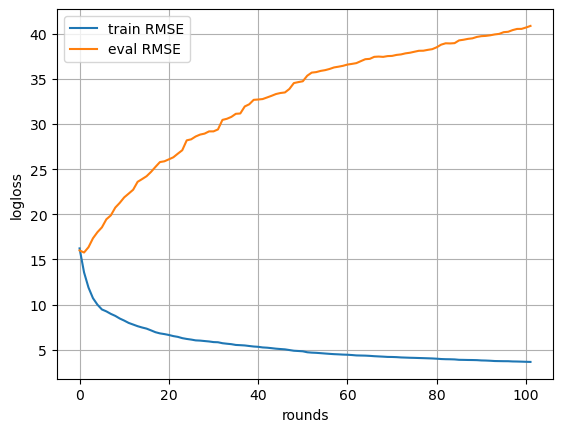

100%|██████████| 30/30 [00:00<00:00, 168.74it/s]


Fold 0:
TN  FP
FN  TP
[[204855    201]
 [   806     17]]
Accuracy: 0.9951087774858047
Recall: 0.020656136087484813
Precision: 0.0779816513761468
F1 score : 0.03266090297790586
---------------------------------------------

[0]	train-rmse:15.45731	eval-rmse:18.16548
[100]	train-rmse:5.50614	eval-rmse:31.47519
[104]	train-rmse:5.43217	eval-rmse:31.72114


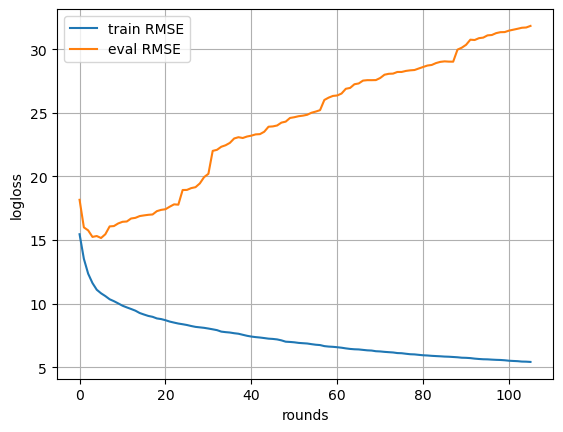

100%|██████████| 30/30 [00:00<00:00, 181.74it/s]


Fold 1:
TN  FP
FN  TP
[[203554   1502]
 [   664    159]]
Accuracy: 0.9894792572336178
Recall: 0.19319562575941676
Precision: 0.09572546658639373
F1 score : 0.1280193236714976
---------------------------------------------

[0]	train-rmse:16.09829	eval-rmse:27.18847
[100]	train-rmse:6.02403	eval-rmse:34.72668
[104]	train-rmse:5.93713	eval-rmse:35.21851


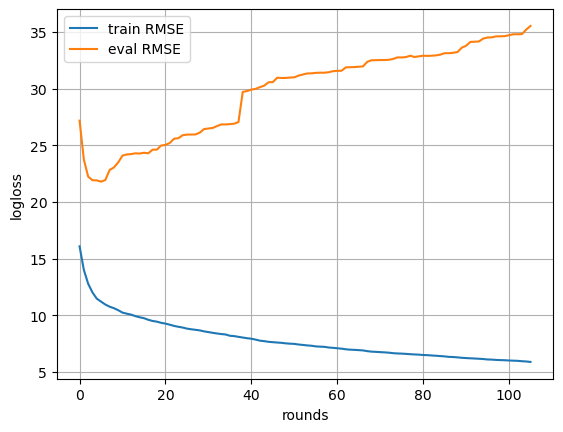

100%|██████████| 30/30 [00:00<00:00, 181.33it/s]


Fold 2:
TN  FP
FN  TP
[[202504   2552]
 [   578    245]]
Accuracy: 0.9847968952637228
Recall: 0.2976913730255164
Precision: 0.08759385055416517
F1 score : 0.13535911602209943
---------------------------------------------

[0]	train-rmse:17.45756	eval-rmse:20.51426
[100]	train-rmse:6.63956	eval-rmse:26.55223
[103]	train-rmse:6.55840	eval-rmse:26.74012


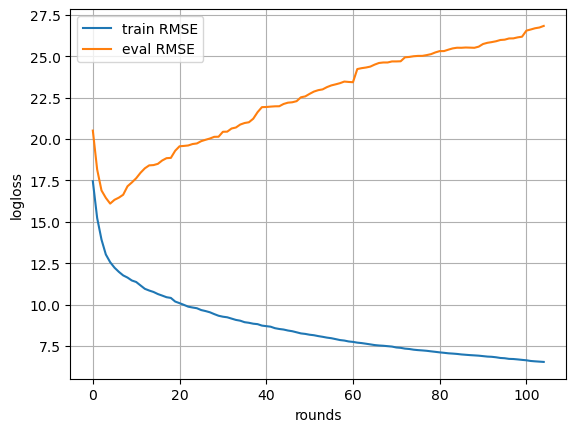

100%|██████████| 30/30 [00:00<00:00, 180.15it/s]


Fold 3:
TN  FP
FN  TP
[[201764   3292]
 [   589    234]]
Accuracy: 0.9811491215714084
Recall: 0.284325637910085
Precision: 0.06636415201361316
F1 score : 0.10761094504483788
---------------------------------------------

[0]	train-rmse:17.96108	eval-rmse:23.09657
[100]	train-rmse:7.43242	eval-rmse:21.54215
[106]	train-rmse:7.31732	eval-rmse:21.57313


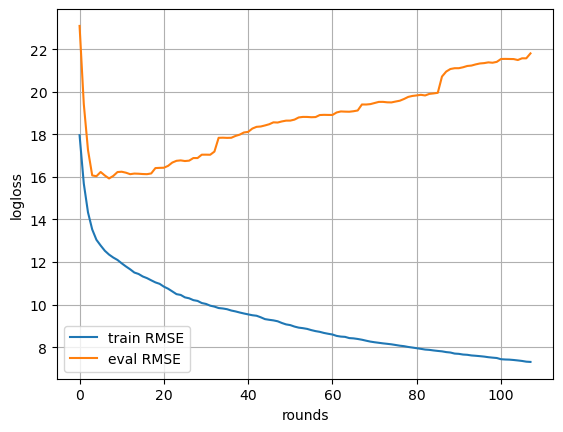

100%|██████████| 30/30 [00:00<00:00, 176.75it/s]


Fold 4:
TN  FP
FN  TP
[[200750   4306]
 [   489    334]]
Accuracy: 0.9767096206995372
Recall: 0.40583232077764275
Precision: 0.07198275862068966
F1 score : 0.12227713710415525
---------------------------------------------



In [197]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

folds = tss(n_splits=5)

test_x_reg = df_test.drop([target, 'is_congestion_tomorrow', 'tomorrow_holiday', 'weight_reg', *ignore_features], axis=1)
test_y_reg = df_test[target]

models = []
predictions = []
weights = []

for fold, (train_index, val_index) in enumerate(folds.split(df_train)):
    
    train, val = df_train.iloc[train_index], df_train.iloc[val_index]
    
    train_y = train[target]
    train_x = train.drop([target, 'is_congestion_tomorrow', 'datetime', 'tomorrow_holiday', 'weight_reg', *ignore_features], axis=1)
    val_y = val[target]
    val_x = val.drop([target, 'is_congestion_tomorrow', 'datetime', 'tomorrow_holiday', 'weight_reg', *ignore_features], axis=1)
    
    weight_train = train['weight_reg']
    weight_val = val['weight_reg']
    
    dtrain = XGB.DMatrix(train_x, label=train_y, weight=weight_train)
    deval = XGB.DMatrix(val_x, label=val_y, weight=weight_val)
    
    evals = [(dtrain, 'train'), (deval, 'eval')]
    
    evals_result = {}
    
    model = XGB.train(xgb_params, dtrain, evals=evals, evals_result=evals_result, num_boost_round=100000, early_stopping_rounds=100, verbose_eval=100)
    
    models.append(model)
    
    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train RMSE')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval RMSE')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()
    
    pred_df = pd.DataFrame(columns=['datetime', 'section', 'prediction'])
    for d, input_df in tqdm(test_x_reg.groupby(test_x_reg['datetime'].dt.date)):
        input = input_df.drop('datetime', axis=1).reset_index(drop=True)
        input = XGB.DMatrix(input)
        pred = model.predict(input)
        preds = input_df[['datetime', 'section']].copy()
        preds['prediction'] = pred
        pred_df = pred_df.append(preds, ignore_index=True) 
    
    answer_df = df_test[['datetime', 'section', 'speed_tomorrow']]
    pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
    pred_df = pred_df.reset_index(drop=True)
    answer_df = pd.merge(answer_df, pred_df, on=['datetime', 'section'], how='inner')
    answer_binary = (answer_df['speed_tomorrow'] <= 40).astype(int)
    prediction_binary = (answer_df['prediction'] <= 40).astype(int)
    
    predictions.append(prediction_binary)
    
    accuracy = accuracy_score(answer_binary, prediction_binary)
    recall = recall_score(answer_binary, prediction_binary)
    precision = precision_score(answer_binary, prediction_binary)
    f1 = f1_score(answer_binary, prediction_binary)
    
    weights.append(f1)

    print(f'Fold {fold}:')
    print('TN  FP\nFN  TP')
    print(confusion_matrix(answer_binary, prediction_binary))
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1 score : {f1}')
    print('---------------------------------------------\n')

In [198]:
majority_predictions = []

for i in range(len(predictions[0])):
    preds = [pred[i] for pred in predictions]
    mode = Counter(preds).most_common(1)[0][0]
    majority_predictions.append(mode)

In [199]:
sub_df = df_test[['datetime', 'start_code', 'end_code', 'KP']]
sub_df['datetime'] = pd.to_datetime(sub_df['datetime'])
sub_df['prediction'] = majority_predictions
sub_df['datetime'] += pd.to_timedelta(1, 'd')
answer_df = pd.merge(sub_df, df_test[['datetime', 'start_code', 'end_code', 'KP', 'holiday', 'is_congestion']], on=['datetime', 'start_code', 'end_code', 'KP'], how='inner')
answer_holiday_df = answer_df.loc[(answer_df['holiday'] == 1)]
answer = answer_df['is_congestion']
answer_holiday = answer_holiday_df['is_congestion']
prediction = answer_df['prediction']
prediction_holiday =answer_holiday_df['prediction']

accuracy = accuracy_score(answer, prediction)
recall = recall_score(answer, prediction)
precision = precision_score(answer, prediction)
f1 = f1_score(answer, prediction)

accuracy_holiday = accuracy_score(answer_holiday, prediction_holiday)
recall_holiday = recall_score(answer_holiday, prediction_holiday)
precision_holiday = precision_score(answer_holiday, prediction_holiday)
f1_holiday = f1_score(answer_holiday, prediction_holiday)

print('Voting:\n')
print('All days')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer, prediction))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 score : {f1}')
print('\n')
print('Only holiday')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer_holiday, prediction_holiday))
print(f'Accuracy: {accuracy_holiday}')
print(f'Recall: {recall_holiday}')
print(f'Precision: {precision_holiday}')
print(f'F1 score : {f1_holiday}')

Voting:

All days
TN  FP
FN  TP
[[196942   1256]
 [   602    179]]
Accuracy: 0.99066233120078
Recall: 0.22919334186939821
Precision: 0.12473867595818815
F1 score : 0.1615523465703971


Only holiday
TN  FP
FN  TP
[[60886   436]
 [  318   110]]
Accuracy: 0.9877894736842106
Recall: 0.2570093457943925
Precision: 0.20146520146520147
F1 score : 0.22587268993839835


In [200]:
model_names = {
    0: "model_xgb_reg_fold_0",
    1: "model_xgb_reg_fold_1",
    2: "model_xgb_reg_fold_2",
    3: "model_xgb_reg_fold_3",
    4: "model_xgb_reg_fold_4",}

save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)

for fold, model in enumerate(models):
    model_name = model_names.get(fold, f'model_xgb_reg_fold_{fold}')
    with open(os.path.join(save_dir, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(model, f)

In [201]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(val_x.reset_index(drop=True))

shap.summary_plot(shap_values, val_x, show=False)
plt.show()

ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

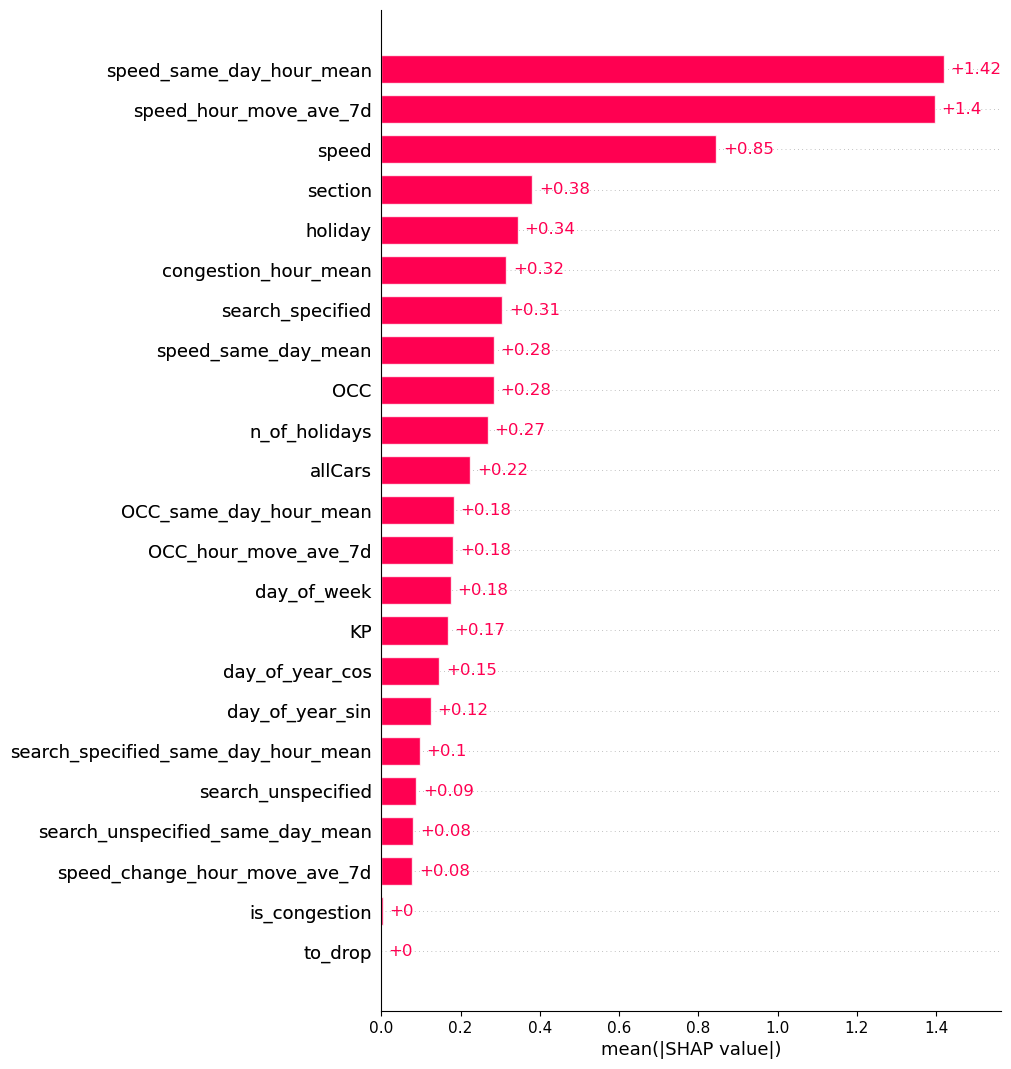

In [ ]:
shap.plots.bar(shap_values, max_display=40)
plt.show()

In [ ]:
#df['datetime'] = pd.to_datetime(df['datetime'])
#
#folds = tss(n_splits=5)
#
#xgb_models = []
#predictions = []
#
#for fold, (train_index, val_index) in enumerate(folds.split(df)):
#    
#    train, val = df.iloc[train_index], df.iloc[val_index]
#    
#    train_y = train[target]
#    train_x = train.drop([target, *ignore_features], axis=1)
#    val_y = val[target]
#    val_x = val.drop([target, *ignore_features], axis=1)
#    
#    # sample_weightに入れる重みを計算
#    weight_train = compute_sample_weight(class_weight='balanced', y=train[target])
#
#    weight_df = pd.DataFrame()
#    weight_df['is_congestion_tomorrow'] = train['is_congestion_tomorrow']
#    weight_df['weight'] = weight_train
#    weight_df.loc[weight_df['is_congestion_tomorrow'] == 0, 'weight'] = (weight_df[weight_df['is_congestion_tomorrow'] == 0]['weight'] * coef_0).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 0].index)
#    weight_df.loc[weight_df['is_congestion_tomorrow'] == 1, 'weight'] = (weight_df[weight_df['is_congestion_tomorrow'] == 1]['weight'] * coef_1).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 1].index)
#    weight_train = weight_df['weight']
#    
#    # optunaでパラメーター探索
#    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=123))
#    study.optimize(objective, timeout=60)
#    
#    xgb_model = XGBClassifier(**study.best_params)
#    xgb_model.fit(train_x, train_y, sample_weight=weight_train)
#    
#    xgb_models.append(xgb_model)

In [ ]:
#shap.decision_plot(explainer.expected_value, explainer.shap_values(val_x), val_x, show=False, ignore_warnings=True)
#plt.show()